# Weakly Supervised 3D Object Detection from Point Clouds (VS3D)
An official implementation of the ACM MM 2020 paper **Weakly Supervised 3D Object Detection from Point Clouds (VS3D)**


## 1. Import the VS3D class
The VS3D class builds the whole network as well as the training and evaluation graphs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import utils
from main import VS3D

vs3d = VS3D(kitti='../data/demo/training',
            train_set='../data/demo/train.txt',
            val_set='../data/demo/val.txt',
            is_training=False)

## 2. Predict the 3D bounding boxes and their 3D point cloud masks
GPUs are not required for evaluation, so we use CPUs in this demo. Among the returned variables, bbox_list stores the sizes, locations and orientations of the predicted 3D bounding boxes. mask_list stores the 3D points inside these boxes.

In [2]:
bbox_list, mask_list, index_list, reader = vs3d.run(
    save_dir='../output',
    lidar_model='../data/pretrained/student/model_lidar_158000',
    return_pred=True, max_pred_frames=100)

INFO:tensorflow:Restoring parameters from ../data/pretrained/student/model_lidar_158000
INFO:tensorflow:Restoring parameters from ../data/pretrained/student/model_lidar_158000
INFO:root:Inference 000098
INFO:root:Forward time: 1.915s, STD: 0.000s


## 3. Visualize the predictions
Then we draw the 3D bounding boxes and point clouds in the 3D space.

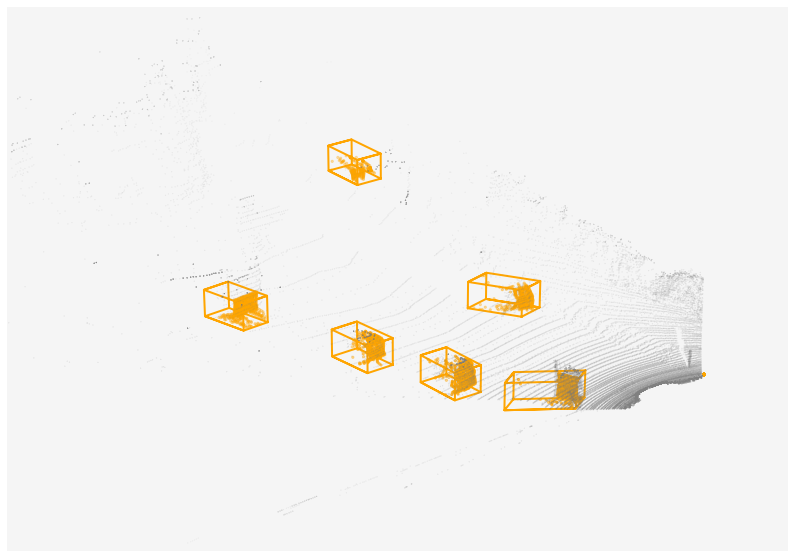

In [3]:
for i, index in enumerate(index_list):
    data = utils.parse_kitti_lines(bbox_list[i])
    masks = mask_list[i]
    image = Image.open(reader.data[index]['image_path'])
    calib = reader.data[index]['P2']
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.gca(projection='3d')
    ax.grid(False)
    ax.set_axis_off()   
    ax.set_facecolor('whitesmoke')
    ax.set_xlim((10, -10))
    ax.set_ylim((5, 35))
    ax.set_zlim((-7, 7))
    ax.view_init(azim=-135, elev=30)
    
    points_cam = utils.read_sphere(
        reader.data[index]['sphere_path'], 
        reader.data[index]['R0'].dot(reader.data[index]['Tr']))
    utils.draw_point_cloud(points_cam, ax, 'grey', 0.005)
    
    for iobj, obj in enumerate(data):
        if obj['score'] < 0.1:
            continue
        dim, loc, rot = obj['dimensions'], obj['location'], obj['rotation_y']
        corners = utils.get_corners(dim, loc, rot)
        utils.draw_space(corners, ax, 'orange', 1.0, linewidth=2)
        points_masked = masks[iobj]
        utils.draw_point_cloud(points_masked, ax, 'orange', 5)
        
    plt.show()    